In [1]:
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard
from keras import backend as K
from functools import partial

Using TensorFlow backend.


## Reproducing sinusoidal functions from noisey ones.

This is an implementation to test our ability to ultimately generate gaussian PDFs from initial generative noise. I adapt this from: Courtesy to [Robin Ricard](http://www.rricard.me/machine/learning/generative/adversarial/networks/keras/tensorflow/2017/04/05/gans-part2.html#Imports) for structure. 

In [32]:
num_samples = 10000
batch_size = 32
num_epochs = 200
mu_range = [-0.5,0.5]
mu_range_val = mu_range[1] - mu_range[0]
loss = 'binary_crossentropy'

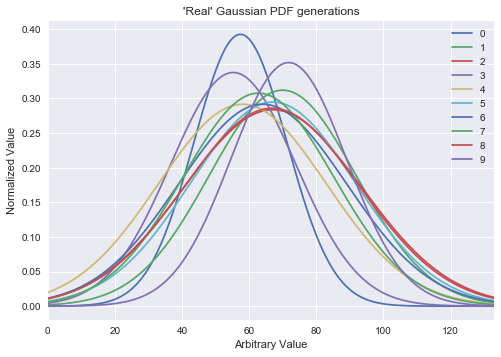

In [3]:
def sample_data(n_samples=num_samples, x_vals=np.arange(-5, 5, .075), max_offset=0.01, mul_range=mu_range, sig_range=[1.0,2.0]):
    vectors = []
    for i in range(n_samples):
        #offset = np.random.random() * max_offset
        mul = np.random.random() * (mul_range[1] - mul_range[0]) - np.random.random()*(mul_range[1] - mul_range[0])
        sig = sig_range[0] + np.random.random() * (sig_range[1] - sig_range[0])
        vectors.append(1 / (np.sqrt(2*np.pi*sig)) * np.exp(-(x_vals - mul)**2 / (2* sig**2)))

    means = np.mean(vectors)
    return np.array(vectors)

ax = pd.DataFrame(np.transpose(sample_data(10))).plot()
ax.set_xlabel("Arbitrary Value")
ax.set_ylabel("Normalized Value")
ax.set_title("'Real' Gaussian PDF generations")

## Make the generative model
It is written as function to tune with hyperparameters. I will add more detail about what the "dense" layer actually is, and how to choose what output dimension to use. Presumably, learning rate (lr) can be chosen to optimize the gradient descent. This can be done with validation. 

In [4]:


def get_generative(G_in, dense_dim=200, out_dim=134, lr=5e-3):
    
    # make a dense layer with output size of dense_dim given G_in
    x = Dense(dense_dim)(G_in)
    
    # apply a tanh activation on each of the nodes
    x = Activation('tanh')(x)
    
    # make dense output layer with chosen output dimension and another tanh activation
    G_out = Dense(out_dim, activation='tanh')(x)
    
    # make the model
    G = Model(G_in, G_out)
    
    # define the optimization, a normal stochastic gradient descent with a chosen learning rate
    opt = SGD(lr=lr)
    
    # compile and define a binary cross entropy loss
    # a description of cross entropy loss http://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

#define shape of input and generate. describe
G_in = Input(shape=[10])
G, G_out = get_generative(G_in)
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               2200      
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 134)               26934     
Total params: 29,134
Trainable params: 29,134
Non-trainable params: 0
_________________________________________________________________


## Make the discriminator

Again all these variables can be tuned. The point currently is to model the setup with any type of data we want to see. 


In [5]:

def get_discriminative(D_in, lr=9e-4, drate=.20, n_channels=50, conv_sz=5, leak=.2):
    
    # Reshape, expanding matrix D_in to be one long column that has n_rows equal to the total size of D_in
    x = Reshape((-1, 1))(D_in)
    
    # make convolutional, define convolution size and number of channels.
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    
    # randomly turn some nodes off, helps prevent overfitting
    x = Dropout(drate)(x)
    
    # flattens x to be a long vector, so can correctly apply dense. 
    # See https://stackoverflow.com/questions/43237124/role-of-flatten-in-keras for more information.
    x = Flatten()(x)
    
    # output into n channels
    x = Dense(n_channels)(x)
    
    # output of length 2, node output follows sigmoid activation
    D_out = Dense(2, activation='sigmoid')(x)
    
    # build the model given D_in and the final D_out
    D = Model(D_in, D_out)
    
    # declare what kind of optimization is used, Adam is a variant of stochastic gradient descent ( has a per 
    # parameter learning rate, updates learning rates according to RMS of recent gradients' steps)
    dopt = Adam(lr=lr)
    
    # compiles with a binary_crossentropy loss
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

# define shape of input and create. describe in summary.
D_in = Input(shape=[134])
D, D_out = get_discriminative(D_in)
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 134)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 134, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 50)           300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 130, 50)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                325050    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total para

## Here two functions are defined: one to ties the two models together, and another to declare which model we freeze for learning purposes at what time.

- set_trainability just declares that, given an input model, we can assign whether or not it and its layers are trainable using a boolean called trainable.
- make_gan takes the generator as input and makes the output the descriminator. The model is then built and compiled frmo there.


In [6]:
## This chains the two models together, update the generator while we freeze the disciminator

def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    
    # discriminator not trained here
    set_trainability(D, False)
    
    # make the generator the input
    x = G(GAN_in)
    
    # make the descriminator the output
    GAN_out = D(x)
    
    # make the model
    GAN = Model(GAN_in, GAN_out)
    
    # compile it with the same loss as the other steps
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

# define input shape and make it !
GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
model_1 (Model)              (None, 134)               29134     
_________________________________________________________________
model_2 (Model)              (None, 2)                 325452    
Total params: 354,586
Trainable params: 29,134
Non-trainable params: 325,452
_________________________________________________________________


In [7]:
def sample_data_and_gen(G, noise_dim=10, n_samples=num_samples):
    
    # produce the sample data using the sample data function we defined above
    XT = sample_data(n_samples=n_samples)
    #print "XT shape: ", XT.shape
    
    # create a noise that is the same size of this sample data
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    
    # make the generator "generate" a distribution from the noise
    XN = G.predict(XN_noise)
    # print "XN shape: ", XN.shape
    
    # concatenate the real data and the generated counterfeit initialization developed from the uniform noise
    X = np.concatenate((XT, XN))
    #print "X shape: ", X.shape
    
    # return the concatenated matrix and create y matrix that says half are real and half are fake, I think
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    #print "y shape: ", y.shape
    return X, y

def pretrain(G, D, noise_dim=10, n_samples=num_samples, batch_size=64):
    
    # initialize everything and now say the discriminator can be trained
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    #print X.shape, y.shape
    
    # make a first fit, the discriminator should do great.
    D.fit(X, y, epochs=1, batch_size=batch_size, verbose=1)

pretrain(G, D)

Epoch 1/1
20000/20000 [==============================] - 9s - loss: 0.0107     


In [8]:
def sample_noise(G, noise_dim=10, n_samples=num_samples):
    
    ### I don't know why this function requires G
    
    
    # make the noise again as we did in the "noise AND gen" function, but now define y such that all of one label
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

def train(GAN, G, D, epochs=num_epochs, n_samples=n_samples, noise_dim=10, batch_size=10, verbose=False, v_freq=40):
    
    # keep track of losses
    d_loss = []
    g_loss = []
    
    # define number of epochs
    e_range = range(epochs)
    
    #print out time information if verbose is True
    if verbose:
        e_range = tqdm(e_range)
        
    # iterate through epochs
    for epoch in e_range:
        
        # make sample data and apply generator to make counterfeit signal
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        
        # make D trainable
        set_trainability(D, True)
        
        # train D and append the loss for that batch
        d_loss.append(D.train_on_batch(X, y))
        
        # make noise again ???
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        
        # train G and append loss
        g_loss.append(GAN.train_on_batch(X, y))
        
        # print out every now and then based on v_freq
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss


# run train and see what losses are. save them for plotting
d_loss, g_loss = train(GAN, G, D, verbose=True)

Epoch #40: Generative Loss: 1.9239423275, Discriminative Loss: 0.401800006628
Epoch #80: Generative Loss: 4.20544433594, Discriminative Loss: 0.059105027467
Epoch #120: Generative Loss: 4.63288116455, Discriminative Loss: 0.0209029782563
Epoch #160: Generative Loss: 6.42308807373, Discriminative Loss: 0.0072975885123
Epoch #200: Generative Loss: 7.6511092186, Discriminative Loss: 0.00411336589605



## Plot the losses on a log scale. 

Ideally, we'd like to see the generator loss decrease significantly, with the discriminator loss slowly increasing to a plateau of indecision. Need to reconsider what metric of loss to use.

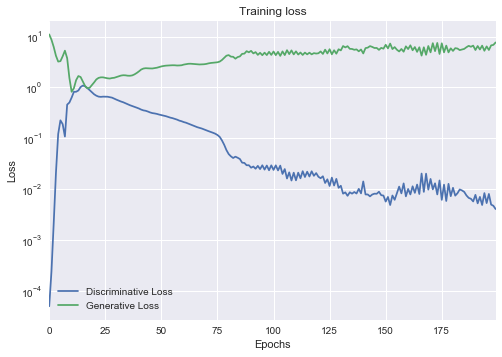

In [34]:
# Plot the losses on a log scale. Ideally, we'd like to see the generator loss decrease significantly,
# with the discriminator loss slowly increasing to a plateau of indecision.
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
fig = ax.get_figure()
fig.savefig('plots/loss/Normal_' + loss + '_' + str(batch_size) + 'batchSize_' + str(num_epochs) + 'epochs_' 
            + str(num_samples) + 'samples_' + str(mu_range_val) + 'muNew.png', format='png' )

## What do our generated sinusoidal images look like? 

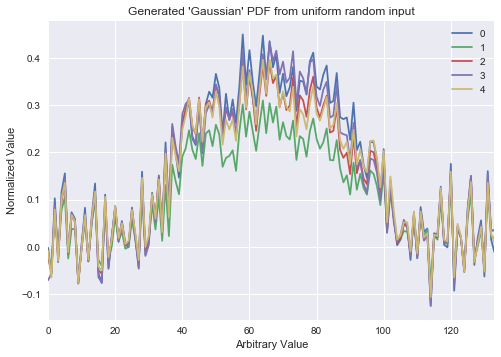

In [35]:
# Generated data. Plotting some examples
N_VIEWED_SAMPLES = 5
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
ax = pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()
ax.set_xlabel("Arbitrary Value")
ax.set_ylabel("Normalized Value")
ax.set_title("Generated 'Gaussian' PDF from uniform random input")

fig = ax.get_figure()
fig.savefig('plots/NormalGeneratedUnSmoothed_' + str(batch_size) + 'batchSize_' + str(num_epochs) + 'epochs_' 
            + str(num_samples) + 'samples_' + str(mu_range_val) + 'muNew.png', format='png' )

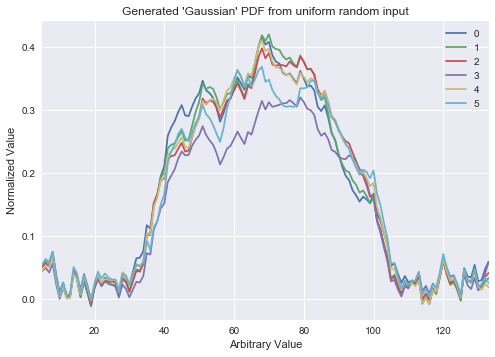

In [30]:
# Smoothed generated data with a rolling mean. Ploting some sample generations

N_VIEWED_SAMPLES = 6
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
ax = pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).rolling(5).mean()[5:].plot()
ax.set_xlabel("Arbitrary Value")
ax.set_ylabel("Normalized Value")
ax.set_title("Generated 'Gaussian' PDF from uniform random input")

fig = ax.get_figure()
fig.savefig('plots/NormalGeneratedSmoothed_' + str(batch_size) + 'batchSize_' + str(num_epochs) + 'epochs_' 
            + str(num_samples) + 'samples_' + str(mu_range_val) + 'muNew.png', format='png' )